In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from scipy.optimize import minimize
import math
import time

In [3]:
class LinearMDP():
    def __init__(self, action_space, seed=1, seed2 = 2, flag=True, cov=True, size=10):
        np.random.seed(seed)

        self.cov=cov
        self.H=3 #Horizon, fixed at 3
        self.state_space = ['x1', 'x2', 'x3', 'x4', 'x5']
        self.action_space = action_space

        self.theta = [np.random.uniform(0, 1, size=size),
                      np.random.uniform(0, 1, size=size),
                      np.random.uniform(0, 1, size=size)]

        self.mu = {'x1':[], 'x2':[], 'x3':[], 'x4':[], 'x5':[]}
        for h in range(self.H): #Normalization of mu over states
            v = np.random.uniform(low=0, high=1, size=(5, size))
            vector_normalized = v / np.sum(v, axis=0, keepdims=True)
            i=0
            for s in self.state_space:
                self.mu[s].append(vector_normalized[i])
                i+=1

        self.phi_dic={}
        self.phi_list = []
        self.phi_dic_og={}
        self.phi_list_og = []
        Q = np.eye(size) #Identity matrix for orthogonal features
        i=0
        for s in self.state_space:
            for a in self.action_space:
                if self.cov==False:
                    phi=Q[i]
                else:
                    p=np.random.uniform(0, 1, size=size)
                    phi_og=p/np.sum(p, axis=0)#original features
                    p+=np.random.normal(0, 0.1, size=size)#add Noise for introducing misspecification
                    phi = p/np.sum(p, axis = 0) #Normalization over dimensions to satisfy example 2.2 in Jin et al. 2023
                self.phi_dic[(s, tuple(a))]=phi #For rewards and transitions
                self.phi_dic_og[(s, tuple(a))]=phi_og #For rewards and transitions
                self.phi_list.append(phi) #For the algorithm
                self.phi_list_og.append(phi_og) #For the algorithm
                i=i+1

        np.random.seed(seed2)#change of seed to induce non-determinism
        self.initial_state = np.random.choice(self.state_space)

    def value_iteration(self):
        V = {(s, h): 0 for s in self.state_space for h in range(self.H+1)}# Initialize value function
        #Apply simple backward induction
        for h in range(self.H-1, -1, -1):
            for s in self.state_space:
                V[(s, h)] = max(sum(self.transition_model(s, a, s_next, h) *
                               (self.reward_function(s, a, h) +  V[(s_next, h+1)])
                               for s_next in self.state_space) for a in self.action_space)
        #Average over the initial states
        su=0
        for s in self.state_space:
            su+=V[(s, 0)]
        return su/len(self.state_space)

    def transition_model(self, s, a, s_next, h):
        prob = []
        for s in self.state_space:
            vec = np.dot(self.phi_dic_og[(s, tuple(a))], self.mu[s][h])
            prob.append(vec)
        prob = {self.state_space[i]: prob[i] for i in range(len(self.state_space))}
        return prob[s_next]

    def reward_function(self, s, a, h):
        return np.dot(self.phi_dic_og[(s, tuple(a))], self.theta[h])

    def reset(self):
        self.initial_state = np.random.choice(self.state_space)
        self.S = [np.random.choice(self.state_space)]
        self.A = [] # save the action history
        self.R = [] # save the reward history
        self.h = 0 # reset the step to 0
        self.feature = [] # save the feature trajectory
        self.feature_a = [] # save the full feature trajectory
        self.current_state = self.initial_state  # reset the current state to initial state

    def add_state(self, s):
        self.S.append(s)
        self.current_state = s


    def update_state(self, phi, h):
        # Calculate the transition probability
        prob = []
        for s in self.state_space:
            vec = np.dot(phi, self.mu[s][h])
            prob.append(vec)

        sprime = np.random.choice(range(0,5), size=1, p=prob)[0]
        return self.state_space[sprime] # return a string

    def next_state(self, phi):
        next_state = self.update_state(phi, self.h)
        self.add_state(next_state)
        return next_state

    def generate_reward(self, phi):
        reward = np.dot(phi, self.theta[self.h])
        return reward

    def generate_best_reward(self):
        rewards = [self.generate_reward(self.phi_dic_og[(self.current_state, tuple(a))]) for a in self.action_space]
        best_reward = max(rewards)
        return best_reward

    def step(self, a):
        self.A.append(a)#Append the action to the history vector
        phi = self.phi_dic_og[(self.current_state, tuple(a))]
        phi_a = [self.phi_dic_og[(self.current_state, tuple(a))] for a in self.action_space]
        self.feature.append(phi)
        self.feature_a.append(phi_a)
        reward = self.generate_reward(phi)
        self.h += 1
        self.R.append(reward) #Append the reward to the history vector




In [4]:
class LSVI_UCB():
    def __init__(self, A, env, beta, H, lam, d=10):
        self.env = env #MDP
        self.d = d #Dimension
        self.lam = lam #Regularization parameter
        self.H = H #Horizon
        self.action_space = A
        self.beta = beta #Exploration bonus
        self.w = [np.zeros(self.d) for _ in range(self.H)] #Estimated parameters
        self.Lambda = [self.lam * np.diag(np.ones(self.d)) for _ in range(self.H)]
        self.Lambda_inv = [np.linalg.inv(s) for s in self.Lambda]

    def value_iteration_pi_k(self):
        # Initialize value function
        V = {(s, h): 0 for s in self.env.state_space for h in range(self.H+1)}
        # Backward induction
        for h in range(self.H-1, -1, -1):
            for s in self.env.state_space:
                a, Q = self.get_action([self.env.phi_dic[(s, tuple(a))] for a in self.action_space], h)
                for s_next in self.env.state_space:
                    V[(s, h)] += self.env.transition_model(s, a, s_next, h) * (self.env.reward_function(s, a, h) +  V[(s_next, h+1)])
        # Average over the initial states
        su=0
        for s in self.env.state_space:
            su+=V[(s, 0)]
        return su/len(self.env.state_space)

    def get_action(self, phi_a,  h):
        Q_h = [self.get_Q_func(phi_a[idx], h) for idx in range(len(self.action_space))]
        return self.action_space[np.argmax(Q_h)], Q_h

    def get_Q_func(self, phi, h):
        # Reward between [0, 1] so we can upperbound the Q-function with H
        Q_h = np.min([self.w[h] @ phi + self.beta * np.sqrt(phi @ self.Lambda_inv[h] @ phi), self.H])
        return Q_h

    def update_Q(self, history):
        # Backward induction
        self.w = [None for _ in range(self.H)] # initialize weights w
        for h in range(self.H-1, -1, -1):
            # update Lambda_h
            phi_h = history['phi'][-1][h]
            self.Lambda[h] += np.outer(phi_h, phi_h)
            # update w_h using the Sherman-Morrison formula for computing Lambda_h inverse

            Lambda_h_inv = self.Lambda_inv[h]

            Lambda_h_inv_phi = np.dot(Lambda_h_inv, phi_h)

            phi_T_Lam_inv = np.dot(phi_h.T, Lambda_h_inv)

            denominator = 1 + np.dot(phi_T_Lam_inv, phi_h)

            self.Lambda_inv[h] = Lambda_h_inv - np.outer(Lambda_h_inv_phi, phi_T_Lam_inv) / denominator
            w_h = np.zeros(self.d)
            if h == self.H - 1: #Treat differently the last step
                for tau in range(history['k']):
                    phi_tau_h = history['phi'][tau][h]
                    r_tau_h = history['r'][tau][h]
                    w_h += self.Lambda_inv[h] @ (phi_tau_h * r_tau_h)

            else:
                for tau in range(history['k']):
                    phi_tau_h = history['phi'][tau][h]
                    phi_tau_h_plus_one = history['phi_a'][tau][h+1]
                    r_tau_h = history['r'][tau][h]
                    Q_tau_h_plus_one = [self.get_Q_func(phi_tau_h_plus_one[idx], h + 1)
                                        for idx in range(len(self.action_space))]
                    V_tau_h_plus_one = np.max(Q_tau_h_plus_one)
                    w_h += self.Lambda_inv[h] @ (phi_tau_h * (r_tau_h + V_tau_h_plus_one))

            self.w[h] = w_h



In [5]:
def train_once(epoch, action_space, beta, H, lam, seed, seed2, d=10, cov=True):
    history = {'k': 0, 'phi':[], 'r':[], 'state':[], 'phi_a':[]}
    env = LinearMDP(action_space, seed=seed, seed2 = seed2, cov=cov, size=d) #Initialize MDP
    agent = LSVI_UCB(A=action_space, env=env, beta=beta, H=H, lam=lam, d=d) #Initialize agent
    V = env.value_iteration() #Compute V^* for the MDP
    reward = 0
    regret = 0
    Reward = []
    Regret = []
    cum_regret = np.zeros(epoch+1)
    for t in range(epoch):
        regret = 0
        env.reset()
        for h in range(H):#Follow policy pi_k
            current_state = env.current_state
            phi_a = [env.phi_dic[(current_state, tuple(a))] for a in action_space]#use misspecified to get action
            action, Q = agent.get_action(phi_a, h)
            env.step(action)
            if h==0:
                Vp = agent.value_iteration_pi_k()
                regret = V-Vp
        # log the trajectory
        cum_regret[t+1]=cum_regret[t]+(regret/V)#Compute cumulative regret
        history['phi_a'].append(env.feature_a)
        history['phi'].append(env.feature)
        history['r'].append(env.R)
        history['state'].append(env.S)
        history['k'] += 1
        # update the agent
        agent.update_Q(history)
        reward += np.sum(env.R)
        Reward.append(reward)
        Regret.append(regret)
    return cum_regret[1:]



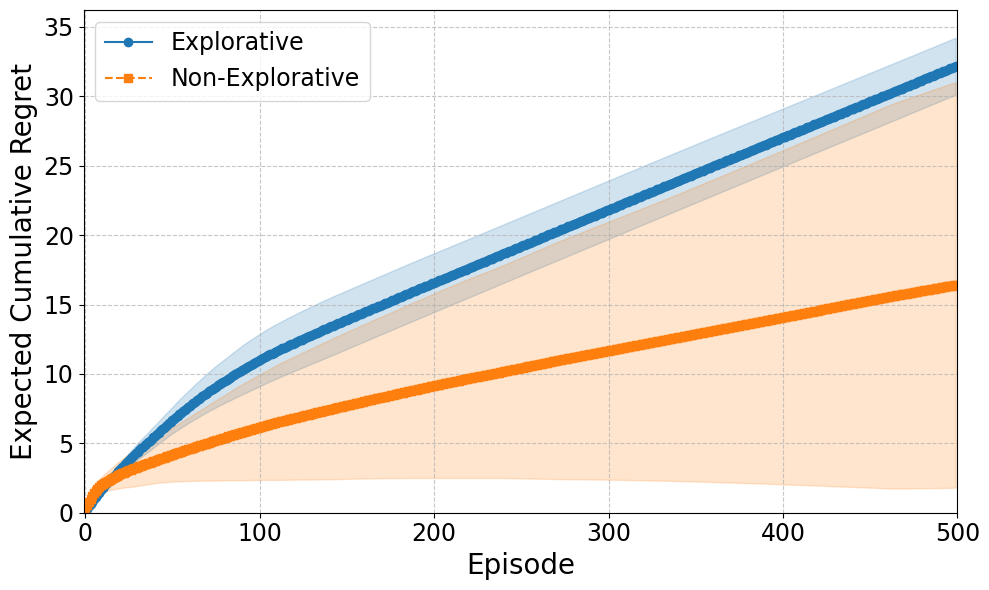

In [7]:
T1 = 500
H = 3
beta = 1
lam = 0.1
actions = [np.random.choice([-1, 1], size=10), np.random.choice([-1, 1], size=10)]
action_space = [np.array(action) for action in actions]
replication = 30
agent_dic = {}
DR_agent_dic = {}
regret_ne = []
regret=[]
regret_ne_2 = []
regret_2=[]
size_cd=3
size_ncd=10
seed = 48765796
seed2 = 8969785
#betas = [1, 0.7, 0.3, 0.1]
#for beta in betas:
regret_ne = []
regret=[]
regret_ne_2 = []
regret_2=[]
for rep in range(replication):
    #Without covariate diversity
      #With exploration
    #regret.append(train_once(epoch=T1, action_space=action_space, beta=beta, H=H, lam=lam, seed=seed2, seed2 = rep, cov=False, d=size_ncd))
      #Without exploration
    #regret_ne.append(train_once(epoch=T1, action_space=action_space, beta=0, H=H, lam=lam, seed=seed2, seed2 = rep, cov=False, d=size_ncd))

    #With covariate diversity
      #With exploration
    regret_2.append(train_once(epoch=T1, action_space=action_space, beta=beta, H=H, lam=lam, seed=seed, seed2 = rep, cov=True, d=size_cd))
      #Without exploration
    regret_ne_2.append(train_once(epoch=T1, action_space=action_space, beta=0, H=H, lam=lam, seed=seed, seed2 = rep, cov=True, d=size_cd))

#regret = np.array(regret)
#regret_ne = np.array(regret_ne)
regret_2 = np.array(regret_2)
regret_ne_2 = np.array(regret_ne_2)

#regret_mean = np.mean(regret, axis=0)
#regret_ne_mean = np.mean(regret_ne, axis=0)
regret_mean_2 = np.mean(regret_2, axis=0)
regret_ne_mean_2 = np.mean(regret_ne_2, axis=0)


#regret_std = np.std(regret, axis=0)
#regret_ne_std = np.std(regret_ne, axis=0)
regret_std_2 = np.std(regret_2, axis=0)
regret_ne_std_2 = np.std(regret_ne_2, axis=0)

# Generate indices based on the length of the vector
indices = range(len(regret_mean_2))

# Create a plot
plt.figure(figsize=(10, 6))

# Plotting the means with improved styles
plt.plot(indices, regret_mean_2, marker='o', linestyle='-', color='#1f77b4', label='Explorative', markersize=6)
plt.plot(indices, regret_ne_mean_2, marker='s', linestyle='--', color='#ff7f0e', label='Non-Explorative', markersize=6)

# Filling between the means and standard deviations
plt.fill_between(indices, regret_mean_2 - regret_std_2, regret_mean_2 + regret_std_2,
                 color='#1f77b4', alpha=0.2)
plt.fill_between(indices, regret_ne_mean_2 - regret_ne_std_2, regret_ne_mean_2 + regret_ne_std_2,
                 color='#ff7f0e', alpha=0.2)

# Extend x and y-axis limits
plt.xlim(-1, len(regret_ne_mean_2))  # Extend x-axis limits beyond the range of indices
plt.ylim(0, max(max(regret_mean_2 + regret_std_2), max(regret_ne_mean_2 + regret_ne_std_2)) + 2)  # Extend y-axis limits beyond the range of values

# Add labels and title
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Expected Cumulative Regret', fontsize=20)
#plt.title('Expected Cumulative Regret Comparison', fontsize=16)
plt.legend(loc='upper left', fontsize=17)

# Add grid and improve layout
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)

# Display the plot
plt.tight_layout()
plt.savefig('covariate_diversity_miss.png', bbox_inches='tight')
plt.show()